In [1]:
import sys
sys.path.append("../")
sys.path.append("../..")

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(14, 4)

In [2]:
# Input
start_time = pd.to_datetime("2021-01-25 00:00:00")
end_time = pd.to_datetime("2021-02-10 00:00:00")

durationList = ['Hour', 'Day', 'Week', 'Month','Year']
feature_cycle = 'Day'
feature_cycle_times = 1

fig_width_num = 4
fig_width = 30
fig_height = 30
duration = {'start_time':start_time, 'end_time':end_time}

modelName="som"
db_name = 'air_indoor_경로당'
ms_name = 'ICL1L2000241'

feature_name = 'in_co2'
freq_min = 60
import datetime
timedelta_frequency_min = datetime.timedelta(minutes= freq_min)

# 3. Nan Processing Parameter
# 3-1. NanLImitProcessingInfo = {'type':'ratio', 'ConsecutiveNanLimit':0.05, 'totalNaNLimit':1} # seconds
# 3-2. NanLImitProcessingInfo = {'type':'time', 'ConsecutiveNanLimit':1*60*60, 'totalNaNLimit':5*60*60} #seconds
# 3-3.
#NanInfoForCleanData = {'type':'num', 'ConsecutiveNanLimit':2, 'totalNaNLimit':20} #27
#NanInfoForCleanData = {'type':'num', 'ConsecutiveNanLimit':1000, 'totalNaNLimit':100000}
NanInfoForCleanData = {'type':'num', 'ConsecutiveNanLimit':1, 'totalNaNLimit':5} #66

## 1. data Prepration

In [3]:
from clust.ingestion.influx import influx_Client_v2 as influx_Client, bucket_data
from setting import influx_setting_KETI as ins
db_client = influx_Client.influxClient(ins.CLUSTDataServer2)

In [4]:
input_data = db_client.get_data_by_time(start_time, end_time, db_name, ms_name)

In [5]:
from Clust.clust.transformation.splitDataByCycle import dataByCycle
# 고른 프리컨시를 갖는 Cycle 데이터가 딕셔너리 형태로 제공됨
dataSet = dataByCycle.getCycleSelectDataSet(input_data, feature_cycle, feature_cycle_times)

## 2. limitation info

In [6]:
from Clust.clust.meta.metaDataManager import bucketMeta
from Clust.clust.ingestion.mongo import mongoClient
#db에서 가져온 데이터로 만든 민맥스
mongo_client = mongoClient.mongoClient(ins.CLUSTMetaInfo2)
min_max = bucketMeta.get_min_max_info_from_bucketMeta(mongo_client, db_name)

## 3. get clustering result

15 ---> 5


/home/keti/CLUST_KETI/Clust/Clust/examples/../../Clust/clust/ML/clustering/kMeans.py:1: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



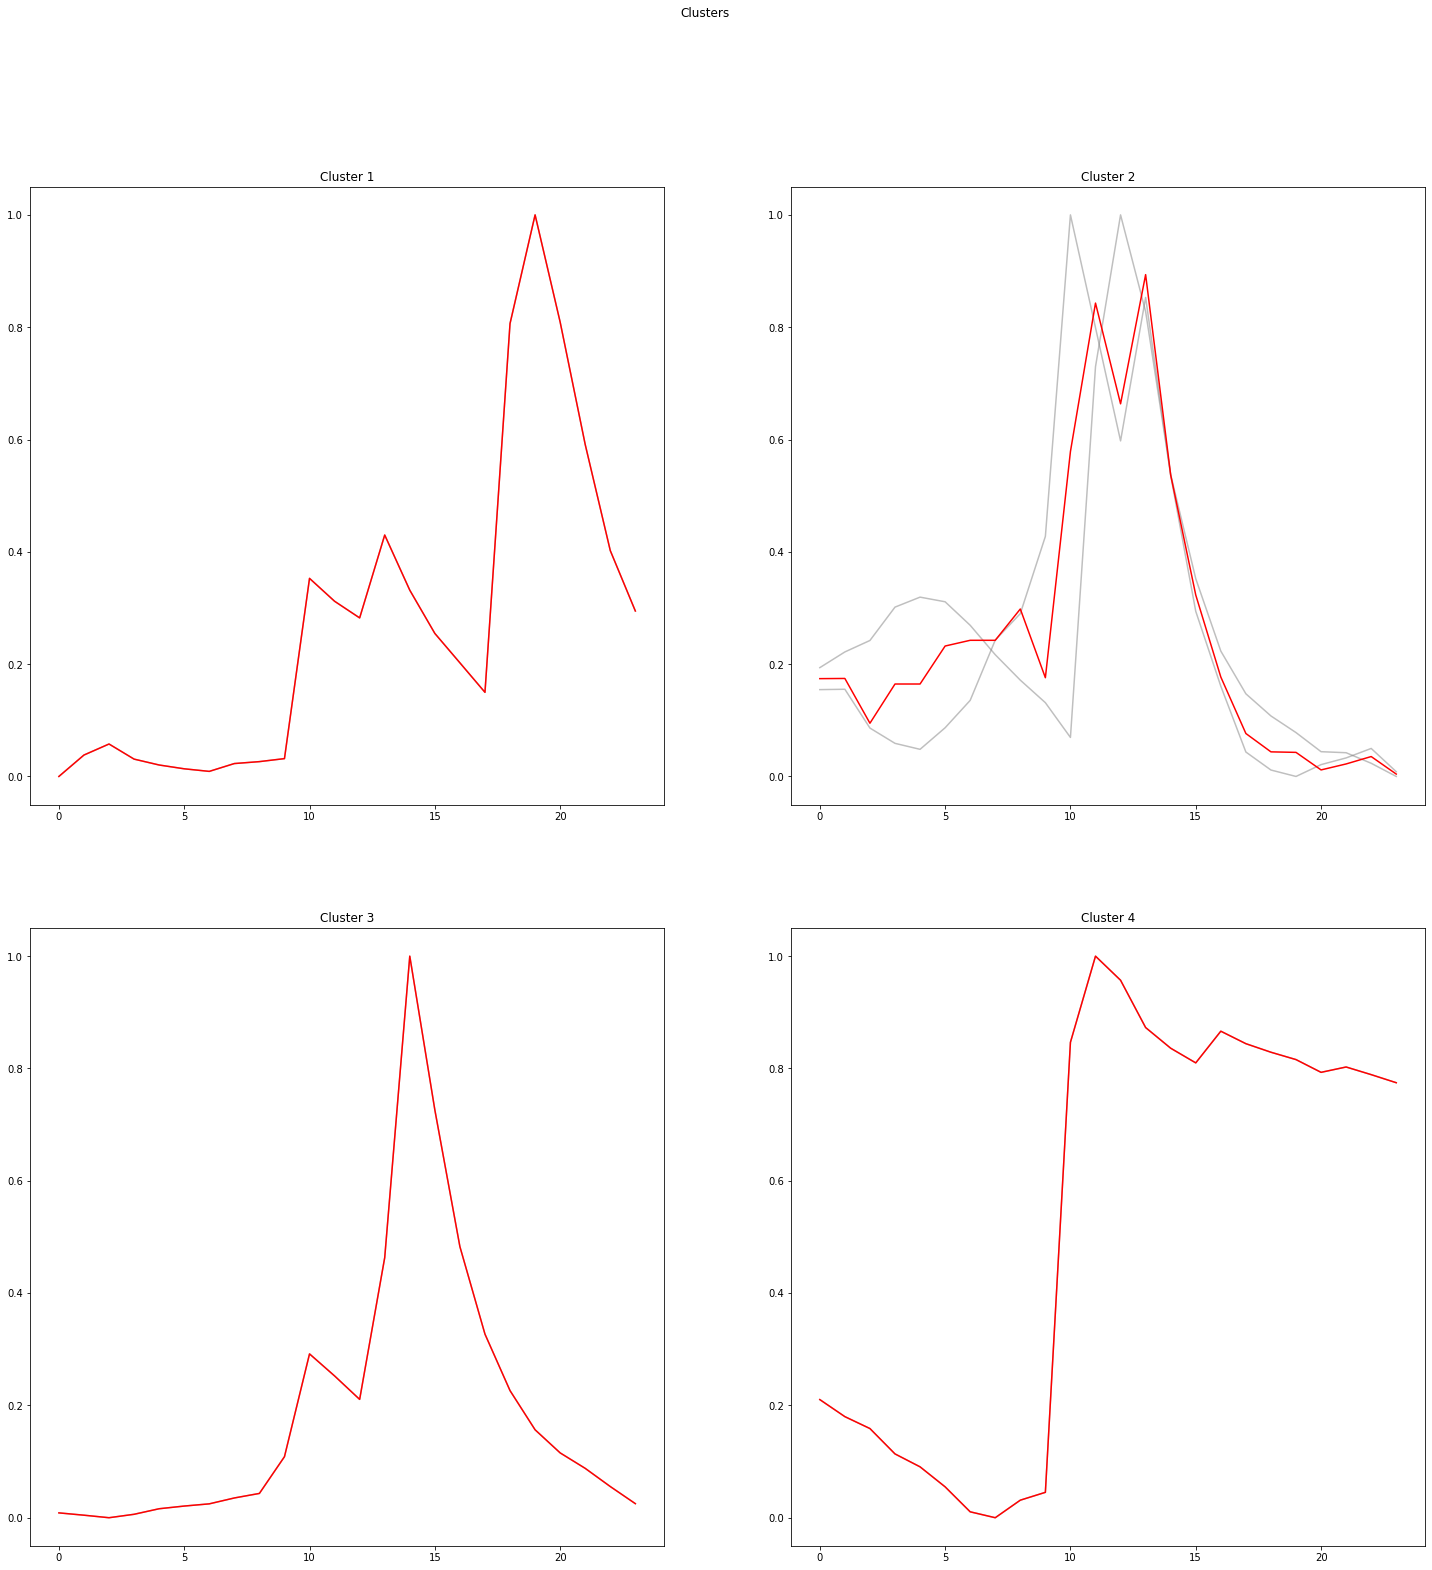

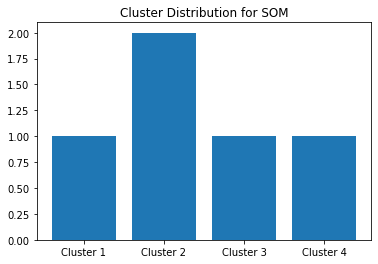

<Figure size 432x288 with 0 Axes>

In [7]:
from Clust.clust.ML.app import usecase 
result, figdata = usecase.get_somClustering_result_from_dataSet(dataSet,feature_name, 
        min_max, timedelta_frequency_min, None, NanInfoForCleanData)

In [8]:
result

{'2021-02-05 00:00:00': '2',
 '2021-02-06 00:00:00': '4',
 '2021-02-07 00:00:00': '3',
 '2021-02-08 00:00:00': '2',
 '2021-02-09 00:00:00': '1'}